# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>
- TAs: Tong Zeng <tozeng@syr.edu>, Priya Matnani <psmatnan@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [25]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

# Part 1. Unsupervised learning

I would recommend to follow the notebook `unsupervised_learning.ipynb` first, shared through the IST 718 repository.

The following dataset contains information about dozens of "data science" programs across the US.

In [26]:
ds_programs_df = spark.read.csv('/datasets/colleges_data_science_programs.csv',
                               inferSchema=True, header=True).\
                 fillna('').orderBy('id')

In [27]:
#ds_programs_df.show()

## Question 1: (10 pts)

This dataset contains many columns that we can use to understand how these data science programs differ from one another. In this question, you will create a dataframe `ds_programs_text_df` which simply adds a column `text` to the dataframe `ds_programs_df`. This column will have the concatenation of the following columns separated by a space: `program`, `degree` and `department` (find the appropriate function in the `fn` package)

In [28]:
# (10 pts) Create ds_programs_text_df here
import pyspark
from pyspark.sql import functions as fn
ds_programs_text_df = ds_programs_df.withColumn('text', \
                      fn.concat(fn.col('program'),fn.lit(' '), fn.col('degree'),fn.lit(' '),fn.col('department')))
#ds_programs_text_df.show(1)

An example of the `ds_programs_text_df` should give you:

```python
ds_programs_text_df.orderBy('id').first().text
```

```console
'Data Science Masters Mathematics and Statistics'
```

In [29]:
# (10 pts)
np.testing.assert_equal(ds_programs_text_df.count(), 222)
np.testing.assert_equal(set(ds_programs_text_df.columns), {'admit_reqs',
 'business',
 'capstone',
 'cost',
 'country',
 'courses',
 'created_at',
 'databases',
 'degree',
 'department',
 'ethics',
 'id',
 'machine learning',
 'mapreduce',
 'name',
 'notes',
 'oncampus',
 'online',
 'part-time',
 'program',
 'program_size',
 'programminglanguages',
 'state',
 'text',
 'university_count',
 'updated_at',
 'url',
 'visualization', 
 'year_founded'})
np.testing.assert_array_equal(ds_programs_text_df.orderBy('id').rdd.map(lambda x: x.text).take(5),
                              ['Data Science Masters Mathematics and Statistics',
 'Analytics Masters Business and Information Systems',
 'Data Science Masters Computer Science',
 'Business Intelligence & Analytics Masters Business',
 'Advanced Computer Science(Data Analytics) Masters Computer Science'])

# Question 2: (10 pts) 

The following code creates a dataframe `ds_features_df` which adds a column `features` to `ds_programs_text_df` that contains the `tfidf` of the column `text`:

In [30]:
# read-only
pipe_features = \
    Pipeline(stages=[
        feature.Tokenizer(inputCol='text', outputCol='words'),
        feature.CountVectorizer(inputCol='words', outputCol='tf'),
        feature.IDF(inputCol='tf', outputCol='tfidf'),
        feature.StandardScaler(withStd=False, withMean=True, inputCol='tfidf', outputCol='features')]).\
    fit(ds_programs_text_df)

Create a pipeline model `pipe_pca` that computes the two first principal components of `features` as computed by `pipe_features` and outputs a column `pc`. Use that pipeline to create a dataframe `ds_features_df` with the columns `id`, `name`, `url`, and `pc`.

In [31]:
# create the pipe_pca PipelineModel below (10 pts)
from pyspark.sql.types import IntegerType
pipe_pca = Pipeline(stages=[pipe_features,feature.PCA(k=2, inputCol='features', outputCol='pc')]).fit(ds_programs_text_df)
principal_components = pipe_pca.stages[-1].pc.toArray()
#principal_components
ds_features_df = pipe_pca.transform(ds_programs_text_df).select('id', 'name', 'url', 'pc')
ds_features_df.select('id', 'name', 'url', 'pc').show()

+---+--------------------+--------------------+--------------------+
| id|                name|                 url|                  pc|
+---+--------------------+--------------------+--------------------+
|  1|South Dakota Stat...|http://www.sdstat...|[-0.1851045942702...|
|  2|Dakota State Univ...|http://www.dsu.ed...|[0.04778735780622...|
|  3|    Lewis University|http://www.lewisu...|[0.15059513165244...|
|  4|Saint Joseph's Un...|http://online.sju...|[-1.0213494464749...|
|  5| University Of Leeds|http://www.engine...|[0.25310990159079...|
|  6|Arizona State Uni...|http://wpcarey.as...|[-0.7124372828488...|
|  7|University Of Cen...|http://dms.stat.u...|[-0.7192035002509...|
|  8|Hong Kong Univers...|http://www.rmbi.u...|[-0.3954566959284...|
|  9|University of Tex...|https://jindal.ut...|[-0.6810101860434...|
| 10|The Ohio State Un...|https://data-anal...|[-0.3117547770561...|
| 11|University of Roc...|http://www.roches...|[-0.0921008008589...|
| 12|         TU Dortmund|http://w

In [32]:
# Tests for (10 pts)
np.testing.assert_equal(pipe_pca.stages[0],  pipe_features)
np.testing.assert_equal(type(pipe_pca.stages[1]),  feature.PCAModel)
np.testing.assert_equal(set(ds_features_df.columns), {'id', 'name', 'pc', 'url'})
np.testing.assert_equal(ds_features_df.first().pc.shape, (2, ))

# Question 3: (10 pts)

Create a scatter plot with the x axis containing the first principal component and the y axis containing the second principal component of `ds_features_df`

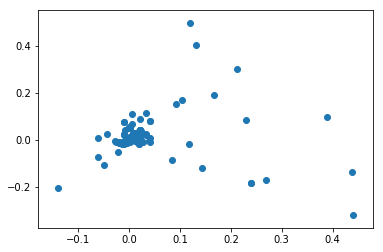

In [33]:
# below perform the appropriate 
# YOUR CODE HERE
pc1 = principal_components[:, 0].tolist()
pc2 = principal_components[:, 1].tolist()
fig, ax = plt.subplots()
ax.scatter(pc1, pc2)

# Question 4 (10 pts)

Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `word` and `abs_loading` that contain the top 5 words in absolute loading for the principal components 1 and 2, respetively. You can extract the vocabulary from the stage that contains the count vectorizer in `pipe_features`:

In [34]:
# YOUR CODE HERE
vocabulary = pipe_features.stages[1].vocabulary
vocabulary
pc_loadings1 = pd.DataFrame([vocabulary, pc1]).T.rename(columns={0: 'word', 1: 'abs_loading'})
pc_loadings2 = pd.DataFrame([vocabulary, pc2]).T.rename(columns={0: 'word', 1: 'abs_loading'})

pc1_pd = pc_loadings1.sort_values('abs_loading').\
         apply({'word': lambda x: x, 'abs_loading': np.abs}, axis=0).head(5)
pc2_pd = pc_loadings2.sort_values('abs_loading').\
         apply({'word': lambda x: x, 'abs_loading': np.abs}, axis=0).head(5)
vocabulary

['masters',
 'data',
 'business',
 'analytics',
 'and',
 'science',
 'mining',
 'computer',
 'statistics',
 'information',
 'intelligence',
 'bachelors',
 'engineering',
 'of',
 'certificate',
 'management',
 'big',
 'sciences',
 'doctorate',
 'computational',
 'systems',
 'machine',
 'school',
 'computing',
 'informatics',
 'learning',
 '&',
 'studies',
 'interdisciplinary',
 'professional',
 'for',
 'college',
 'analysis',
 'none',
 'knowledge',
 'applied',
 'mathematics',
 'social',
 'predictive',
 'institute',
 'astronomy,',
 'continuing',
 'physics,',
 'in',
 'advanced',
 'decision',
 'extension',
 'concentration',
 'artificial',
 'development',
 'center',
 'marketing',
 'graduate',
 'quality',
 "master's",
 'cloud',
 'minor',
 'humanities',
 'programs',
 'consulting',
 'web',
 'specialization',
 '',
 'massive',
 'analytic',
 'software',
 'science)',
 'uci',
 'automatic',
 'sas',
 '-',
 'science,',
 'liberal',
 'science:',
 'industrial',
 'graham',
 'discovery',
 'usiness',
 '(',


In [35]:
pc1_pd

,word,abs_loading
2,business,0.138929
6,mining,0.0605211
3,analytics,0.0599323
10,intelligence,0.0498404
8,statistics,0.0421918


In [36]:
pc2_pd

,word,abs_loading
19,computational,0.317074
2,business,0.201894
42,"physics,",0.18139
40,"astronomy,",0.18139
22,school,0.169347


In [37]:
# (10 pts)
assert type(pc1_pd) == pd.core.frame.DataFrame
assert type(pc2_pd) == pd.core.frame.DataFrame
np.testing.assert_array_equal(pc1_pd.shape, (5, 2))
np.testing.assert_array_equal(pc2_pd.shape, (5, 2))
np.testing.assert_equal(set(pc1_pd.columns), {'abs_loading', 'word'})
np.testing.assert_equal(set(pc2_pd.columns), {'abs_loading', 'word'})

# Question 5: (10 pts)

Create a new pipeline for PCA called `pipe_pca2` where you fit 50 principal components. Extract the the `PCAModel` from the stages of this pipeline, and assign to a variable `explainedVariance` the variance explained by components of such model. Finally, assign to a variable `best_k` the value $k$ such that ($k+1$)-th component is not able to explain more than 0.01 variance. You can use a for-loop to find such best k.

In [39]:
# YOUR CODE HERE
pipe_pca2 = Pipeline(stages=[pipe_features,feature.PCA(k=50, inputCol='features', outputCol='pc')]).fit(ds_programs_text_df)
explainedVariance = pipe_pca2.stages[-1].explainedVariance
explainedVariance
for i in range(0,len(explainedVariance)-1):
    if((explainedVariance[i+1])<=0.01):
        temp = i
        break        
best_k = temp
print("best k:",best_k)

best k: 31


In [40]:
# Tests for (10 pts)
np.testing.assert_equal(pipe_pca2.stages[0],  pipe_features)
np.testing.assert_equal(type(pipe_pca2.stages[1]),  feature.PCAModel)
np.testing.assert_equal(len(explainedVariance), 50)
np.testing.assert_array_less(5, best_k)